# 학습된 모델 저장

- 학습이 완료된 모델을 파일로 저장하여, 이후 추가 학습이나 예측 서비스에 사용할 수 있도록 한다.
- 파이토치(PyTorch)는 **모델의 파라미터만 저장**하는 방법과 **모델의 구조와 파라미터를 모두 저장**하는 두 가지 방식을 제공한다.
- 저장 함수
  - `torch.save(저장할 객체, 저장 경로)`
- 보통 저장 파일의 확장자는 `.pt`나 `.pth`를 사용한다.

## 모델 전체 저장 및 불러오기

- 저장하기
  - `torch.save(model, 저장 경로)`
- 불러오기
  - `load_model = torch.load(저장 경로, weights_only=False)`
- 모델 저장 시 **피클(pickle)**을 사용해 직렬화되므로, 모델을 불러오는 실행 환경에도 저장할 때 사용한 클래스 정의가 필요하다.


## 모델의 파라미터만 저장

-   모델을 구성하는 파라미터만 저장한다.
-   모델의 구조는 저장하지 않기 때문에 불러올 때 **모델을 먼저 생성하고 생성한 모델에 불러온 파라미터를 덮어씌운다.**
-   모델의 파라미터는 **state_dict** 형식으로 저장한다.

### state_dict

-   모델의 파라미터 Tensor들을 레이어 단위별로 나누어 저장한 Ordered Dictionary (OrderedDict)
-   `모델객체.state_dict()` 메소드를 이용해 조회한다.
-   모델의 state_dict을 조회 후 저장한다.
    -   `torch.save(model.state_dict(), "저장경로")`
-   생성된 모델에 읽어온 state_dict를 덮어씌운다.
    -   `new_model.load_state_dict(torch.load("state_dict저장경로"))`


## Checkpoint 저장 및 불러오기

- 학습이 끝나지 않은 모델을 저장하고, 나중에 이어서 학습시키려면 모델의 구조와 파라미터뿐만 아니라 optimizer, loss 함수 등 학습에 필요한 객체들도 함께 저장해야 한다.
- 딕셔너리(Dictionary)에 저장하려는 값들을 key-value 쌍으로 구성하여 `torch.save()`를 이용해 저장한다.

```python
# 저장
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss
}, "저장경로")

# 불러오기
model = MyModel()
optimizer = optim.Adam(model.parameters())

# 불러온 checkpoint를 이용해 이전 학습 상태 복원
checkpoint = torch.load("저장경로")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
```

In [35]:
# 간단한 모델 정의
import torch
import torch.nn as nn

class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(3, 4) # 3 X 4 + 4 
        self.lr2 = nn.Linear(4, 2)
        self.relu = nn.ReLU() # activation함수->파라미터가 없는 단순 계산함수. relu(X) = max(X, 0)
    def forward(self, X):
        X = self.lr1(X)
        X = self.relu(X)
        X = self.lr2(X)
        return X

In [36]:
# 모델 생성성
model = MyModel()
model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [37]:
################################################
#  모델에 Layer들을 조회. 모델.instance변수명
################################################
lr_layer = model.lr1
lr_layer

Linear(in_features=3, out_features=4, bias=True)

In [4]:
################################################
#  Layer의 파라미터(weight/bias) 조회
################################################
lr1_weight = lr_layer.weight
lr1_bias = lr_layer.bias

In [6]:
print(lr1_weight.size())
lr1_weight

torch.Size([4, 3])


Parameter containing:
tensor([[-0.0990, -0.2017,  0.3291],
        [ 0.3617,  0.4953,  0.0188],
        [ 0.1496, -0.5085,  0.0211],
        [-0.3762,  0.0578, -0.0185]], requires_grad=True)

In [7]:
lr1_bias

Parameter containing:
tensor([ 0.2466,  0.1807, -0.4694, -0.3903], requires_grad=True)

In [8]:
import os
os.makedirs("saved_models", exist_ok=True)

In [9]:
################################################
#  모델을 저장
################################################
torch.save(model, "saved_models/my_model.pt")

In [12]:
################################################
#  저장된 모델 Load
################################################
load_model = torch.load("saved_models/my_model.pt", weights_only=False)

In [13]:
load_model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [14]:
load_model.lr1.weight

Parameter containing:
tensor([[-0.0990, -0.2017,  0.3291],
        [ 0.3617,  0.4953,  0.0188],
        [ 0.1496, -0.5085,  0.0211],
        [-0.3762,  0.0578, -0.0185]], requires_grad=True)

In [15]:
lr1_weight

Parameter containing:
tensor([[-0.0990, -0.2017,  0.3291],
        [ 0.3617,  0.4953,  0.0188],
        [ 0.1496, -0.5085,  0.0211],
        [-0.3762,  0.0578, -0.0185]], requires_grad=True)

In [16]:
######################################################
# 모델의 파라미터들(weight들, bias들)만 저장/불러오기
######################################################
state_dict = model.state_dict()
state_dict

OrderedDict([('lr1.weight',
              tensor([[-0.0990, -0.2017,  0.3291],
                      [ 0.3617,  0.4953,  0.0188],
                      [ 0.1496, -0.5085,  0.0211],
                      [-0.3762,  0.0578, -0.0185]])),
             ('lr1.bias', tensor([ 0.2466,  0.1807, -0.4694, -0.3903])),
             ('lr2.weight',
              tensor([[-0.1697, -0.2790,  0.1483,  0.3806],
                      [ 0.0087, -0.2120, -0.2670, -0.0226]])),
             ('lr2.bias', tensor([-0.2744,  0.2594]))])

In [17]:
state_dict.keys()

odict_keys(['lr1.weight', 'lr1.bias', 'lr2.weight', 'lr2.bias'])

In [18]:
###################
# state_dict 저장
################### 
torch.save(state_dict, "saved_models/my_model_parameter.pt")

In [ ]:
#####################
# state_dict load
#####################
sd = torch.load("saved_models/my_model_parameter.pt")  #weight_only=True (default)
sd

OrderedDict([('lr1.weight',
              tensor([[-0.0990, -0.2017,  0.3291],
                      [ 0.3617,  0.4953,  0.0188],
                      [ 0.1496, -0.5085,  0.0211],
                      [-0.3762,  0.0578, -0.0185]])),
             ('lr1.bias', tensor([ 0.2466,  0.1807, -0.4694, -0.3903])),
             ('lr2.weight',
              tensor([[-0.1697, -0.2790,  0.1483,  0.3806],
                      [ 0.0087, -0.2120, -0.2670, -0.0226]])),
             ('lr2.bias', tensor([-0.2744,  0.2594]))])

In [26]:
# load한 state_dict를 모델 파라미터에 적용(덮어 씌운다.)
new_model = MyModel()
# new_model.state_dict()

In [24]:
new_model.load_state_dict(sd)

<All keys matched successfully>

In [ ]:
new_model.state_dict()

OrderedDict([('lr1.weight',
              tensor([[-0.0990, -0.2017,  0.3291],
                      [ 0.3617,  0.4953,  0.0188],
                      [ 0.1496, -0.5085,  0.0211],
                      [-0.3762,  0.0578, -0.0185]])),
             ('lr1.bias', tensor([ 0.2466,  0.1807, -0.4694, -0.3903])),
             ('lr2.weight',
              tensor([[-0.1697, -0.2790,  0.1483,  0.3806],
                      [ 0.0087, -0.2120, -0.2670, -0.0226]])),
             ('lr2.bias', tensor([-0.2744,  0.2594]))])

In [27]:
print(model)

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)


In [28]:
# torchinfo 패키지 설치: 파이토치 모델 구조를 조사해주는 패키지.
!uv pip install torchinfo

Resolved 1 package in 48ms
Installed 1 package in 30ms
 + torchinfo==1.8.0


In [29]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MyModel                                  --
├─Linear: 1-1                            16
├─Linear: 1-2                            10
├─ReLU: 1-3                              --
Total params: 26
Trainable params: 26
Non-trainable params: 0

In [40]:
# input data 의 shape을 지정하면 각 Layer의 output shape을 출력한다.
summary(model, (100, 3))  # input_data=입력Tensor객체, input_data=torch.randn(100, 3)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [100, 2]                  --
├─Linear: 1-1                            [100, 4]                  16
├─ReLU: 1-2                              [100, 4]                  --
├─Linear: 1-3                            [100, 2]                  10
Total params: 26
Trainable params: 26
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

# 문제 유형별 MLP 네트워크
- 해결하려는 문제 유형에 따라 출력 Layer의 구조가 바뀐다.
- 딥러닝 구조에서 **Feature를 추출하는 Layer 들을 Backbone** 이라고 하고 **추론하는 Layer들을 Head** 라고 한다. 


> - MLP(Multi Layer Perceptron), DNN(Deep Neural Network), ANN(Artificial Neural Network)
>     -   Fully Connected Layer(nn.Linear)로 구성된 딥러닝 모델
>     -   input feature들 모두에 대응하는 weight들(가중치)을 사용한다.
> 

## Boston Housing Dataset - **Regression(회귀) 문제**

보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.

-   CRIM: 범죄율
-   ZN: 25,000 평방피트당 주거지역 비율
-   INDUS: 비소매 상업지구 비율
-   CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
-   NOX: 일산화질소 농도(단위: 0.1ppm)
-   RM: 주택당 방의 수
-   AGE: 1940년 이전에 건설된 주택의 비율
-   DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
-   RAD: 고속도로 접근성
-   TAX: 재산세율
-   PTRATIO: 학생/교사 비율
-   B: 흑인 비율
-   LSTAT: 하위 계층 비율
    <br><br>
-   **Target**
    -   MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)


In [120]:
import pandas as pd

df = pd.read_csv('data/boston_housing.csv')
print(df.shape)

(506, 14)


In [121]:
X = df.drop(columns='MEDV').values
y = df['MEDV'].values.reshape(-1, 1)
X.shape, y.shape

((506, 13), (506, 1))

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [124]:
# Train/Test Dataset
from torch.utils.data import TensorDataset
trainset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)

testset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

len(trainset), len(testset)

(404, 102)

In [125]:
# DataLoader 생성
batch_size = 200
from torch.utils.data import DataLoader
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=len(testset))

In [ ]:
##########################
# 모델 정의
##########################
import torch
import torch.nn as nn
class BostonModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(13, 32) # 첫번째 연산
        self.lr2 = nn.Linear(32, 16)
        self.lr3 = nn.Linear(16, 1)   
        # 추론 결과를 출력 : 회귀 - 예측할 값의 개수.(집값: 1, 아파트,단독,연립: 3), y.shape: (N, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        # Linear -> ReLU -> Linear -> ReLU -> Liear -> 출력
        out = self.lr1(X)
        out = self.relu(out)        
        out = self.lr2(out)
        out = self.relu(out)
        out = self.lr3(out)
        return out

In [ ]:
epochs = 1000
lr = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loss_list = []
valid_loss_list = []

# 모델 생성
boston_model = ().to(device)
# Loss 함수BostonModel
loss_fn = nn.MSELoss()
# Optimizer
optimizer = torch.optim.RMSprop(boston_model.parameters(), lr=lr)

In [128]:
from torchinfo import summary
summary(boston_model, (200, 13), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [200, 1]                  --
├─Linear: 1-1                            [200, 32]                 448
├─ReLU: 1-2                              [200, 32]                 --
├─Linear: 1-3                            [200, 16]                 528
├─ReLU: 1-4                              [200, 16]                 --
├─Linear: 1-5                            [200, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [132]:
# Train -> Train / Validataion 두 단계
for epoch in range(epochs):
    #####################################
    # 학습(train)
    #####################################
    boston_model.train()
    train_loss = 0.0 # 현 에폭의 loss을 저장할 변수.
    for X_train, y_train in train_loader:  # 1 배치 학습
        # 1. X, y를 device로 이동. (model 과 같은 device로 이동)
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 추론
        pred_train = boston_model(X_train)
        # 3. Loss 계산
        loss = loss_fn(pred_train, y_train)
        # 4. 역전파로 gradient 계산
        loss.backward()
        # 5. 파라미터 업데이트
        optimizer.step()
        # 6. gradient 초기화
        optimizer.zero_grad()
        # 7. 현재 batch에대한 loss 계산
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    #####################################
    # 검증(valiation) - 1 에폭 학습한 것에 대한 검증
    #####################################
    boston_model.eval() # 추론만 할 때.

    valid_loss = 0.0 # 현재 epoch에 대한 검증 loss값을 저장할 변수
    with torch.no_grad():
        for X_valid, y_valid in test_loader:
            # 1. X, y를 model의 device로 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            
            # 2. 추론
            pred_valid = boston_model(X_valid)

            # 3. 평가 - MSE
            valid_loss  += loss_fn(pred_valid, y_valid).item()
        valid_loss = valid_loss / len(test_loader)
        valid_loss_list.append(valid_loss)
    # 로그 출력 - train/valid loss를 출력
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"[{epoch+1}/{epochs}] train loss: {train_loss:.5f}, validation loss: {valid_loss:.5f}")

[1/1000] train loss: 594.42477, validation loss: 515.35468
[101/1000] train loss: 23.58760, validation loss: 23.97379
[201/1000] train loss: 14.93035, validation loss: 16.34781
[301/1000] train loss: 10.74346, validation loss: 12.26301
[401/1000] train loss: 8.04014, validation loss: 10.85579
[501/1000] train loss: 6.96515, validation loss: 10.33121
[601/1000] train loss: 6.27835, validation loss: 10.23465
[701/1000] train loss: 5.61462, validation loss: 9.93723
[801/1000] train loss: 5.18579, validation loss: 9.94390
[901/1000] train loss: 4.64167, validation loss: 9.82463
[1000/1000] train loss: 4.28705, validation loss: 9.83201


In [ ]:
save_boston_model_path = "saved_models/boston_model.pth"
torch.save(boston_model, save_boston_model_path) # 모델 전체 저장
torch.save(boston_model.state_dict(), "saved_models/bost_model_parameter.pth") # 모델 파라미터만 저장

In [145]:
load_model = torch.load(save_boston_model_path, weights_only=False)
load_model.eval()
with torch.no_grad():
    print(load_model(X_valid)[:10])

tensor([[26.8538],
        [35.7528],
        [15.9317],
        [24.0498],
        [16.7013],
        [19.5364],
        [17.8356],
        [15.4498],
        [26.5210],
        [18.9611]])


In [146]:
load_state_dict = torch.load("saved_models/bost_model_parameter.pth", weights_only=True)
new_model = BostonModel()
new_model.load_state_dict(load_state_dict)
new_model.eval()
with torch.no_grad():
    result = new_model(X_valid)[:10]
    print(result)

tensor([[26.8538],
        [35.7528],
        [15.9317],
        [24.0498],
        [16.7013],
        [19.5364],
        [17.8356],
        [15.4498],
        [26.5210],
        [18.9611]])


## 분류 (Classification)

### Fashion MNIST Dataset - **다중분류(Multi-Class Classification) 문제**

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋.
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

- **Feature**이미지는 28x28 크기이며 Gray scale이다.
- **Target**은 총 10개의 class로 구성되어 있으며 각 class의 class 이름은 다음과 같다.

| 레이블 | 클래스       |
|--------|--------------|
| 0      | T-shirt/top |
| 1      | Trousers    |
| 2      | Pullover    |
| 3      | Dress       |
| 4      | Coat        |
| 5      | Sandal      |
| 6      | Shirt       |
| 7      | Sneaker     |
| 8      | Bag         |
| 9      | Ankle boot  |

> #### 학습 도중 모델 저장
>
> - 학습 도중 가장 좋은 성능을 보이는 모델이 나올 수 있다.
> - 학습 도중 모델을 저장하는 방법
>   1. 각 에폭이 끝날 때 마다 모델을 저장한다.
>   2. 한 에폭 학습 후 성능 개선이 있으면 모델을 저장하여 가장 성능 좋은 모델만 저장되도록 한다.
>      - 최고 성능 점수(best score)와 현재 에폭의 성능을 비교하여, 성능이 개선되었을 경우 모델을 저장(덮어쓰기)한다.
>
> #### 조기 종료(Early Stopping)
>
> - 학습 도중 성능 개선이 나타나지 않으면, 중간에 학습을 종료하도록 구현한다.
> - 에폭 수를 충분히 길게 설정한 뒤, 특정 횟수 동안 성능 개선이 없으면 학습을 조기 종료하도록 구현한다.


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "mps" if torch.backend.mps.is_available() else "cpu"
device

'cpu'

In [17]:
# Dataset 
batch_size = 256
dataset_path = "datasets/fashion_mnist"
f_trainset = FashionMNIST(dataset_path, train=True, download=True, transform=transforms.ToTensor())
f_testset = FashionMNIST(dataset_path, train=False, download=True, transform=transforms.ToTensor())
f_trainset, f_validset = random_split(f_trainset, [50000, 10000])

f_train_loader = DataLoader(f_trainset, batch_size=batch_size, shuffle=True, drop_last=True)
f_valid_loader = DataLoader(f_validset, batch_size=batch_size)
f_test_loader = DataLoader(f_testset, batch_size=batch_size)

len(f_trainset), len(f_testset), len(f_validset), len(f_train_loader), len(f_test_loader)

(50000, 10000, 10000, 195, 40)

In [8]:
f_testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
f_testset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [29]:
print(f_trainset[0][0].dtype)
print(f_trainset[0][0].size())
print(f_trainset[0][0].min(), f_trainset[0][0].max())

torch.float32
torch.Size([1, 28, 28])
tensor(0.) tensor(1.)


In [ ]:
##################################
# 모델 정의
##################################
class FashionMNISTModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(784, 2048)
        self.lr2 = nn.Linear(2048, 1024)
        self.lr3 = nn.Linear(1024, 512)
        self.lr4 = nn.Linear(512, 256)
        self.lr5 = nn.Linear(256, 128)
        self.lr6 = nn.Linear(128, 64)
        self.lr7 = nn.Linear(64, 10)
        # 출력 Layer out_features 개수: 다중분류문제의 경우 정답 클래스 개수.
        self.relu = nn.ReLU()

    def forward(self, X):
        # X shape: (batch, 1, 28, 28) -> (batch, 784) torch.flatten(start_dim=1)함수
        out = nn.Flatten()(X) # 0축은 그대로 두고 그 이후 축을 flatten 한다.
        out = self.lr1(out)  # self.relu(self.lr1(out))
        out = self.relu(out)

        out = self.lr2(out) 
        out = self.relu(out)

        out = self.lr3(out) 
        out = self.relu(out)

        out = self.lr4(out) 
        out = self.relu(out)

        out = self.lr5(out) 
        out = self.relu(out)

        out = self.lr6(out) 
        out = self.relu(out)

        out = self.lr7(out) 
        return out

In [ ]:
# !uv pip install torchinfo

In [38]:
from torchinfo import summary
summary(FashionMNISTModel(), (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModel                        [100, 10]                 --
├─Linear: 1-1                            [100, 2048]               1,607,680
├─ReLU: 1-2                              [100, 2048]               --
├─Linear: 1-3                            [100, 1024]               2,098,176
├─ReLU: 1-4                              [100, 1024]               --
├─Linear: 1-5                            [100, 512]                524,800
├─ReLU: 1-6                              [100, 512]                --
├─Linear: 1-7                            [100, 256]                131,328
├─ReLU: 1-8                              [100, 256]                --
├─Linear: 1-9                            [100, 128]                32,896
├─ReLU: 1-10                             [100, 128]                --
├─Linear: 1-11                           [100, 64]                 8,256
├─ReLU: 1-12                             [100, 64]    

In [42]:
f_model = FashionMNISTModel().to(device)
optimizer = torch.optim.Adam(f_model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss() 
# 다중분류의 loss: CrossEntropyLoss()
# CrossEntrpyLoss()입력: 정답-class index로 구성 [[3],[8],[0]..], 모델 추정결과: Softmax를 적용하기 전값 - logit

In [ ]:
import time

train_loss_list = []
valid_loss_list = []
valid_acc_list = []

##################################################################
# 1. 성능(valid_loss)이 개선될 때 마다 모델을 저장.
#    최종적으로 가장 성능이 좋은 epoch의 모델이 저장되도록한다.
# 2. 일정 epoch동안 성능개선이 안되면 학습을 중단.
# 이것과 관련된 변수들 정의.
##################################################################
best_score = torch.inf  # 가장 좋은 valid_loss 값을 저장. valid_loss < best_score 성능개선 -> 저장.
# 저장
save_model_path = "saved_models/fashion_mnist_model.pth"
# 조기종료
patience = 10  # 성능이 개선되는지 10 에폭 동안 기다려본다. valid_loss >= best_score 성능개선이 안됨. 
stop_count = 0 # 학습하는 도중 몇 번동안 성능개선이 안되었는지 저장할변수. stop_count == patience 이면 종료.

epochs = 100
s = time.time()
for epoch in range(epochs):
    # 학습
    f_model.train()

    train_loss = 0.0
    for X_train, y_train in f_train_loader:
        # 1. X, y를 device로 이동
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 모델 추론
        pred_train = f_model(X_train)
        # 3. loss 계산
        loss = loss_fn(pred_train, y_train)
        # 4. gradient 계산  (역전파)
        loss.backward()
        # 5. 파라미터 업데이트
        optimizer.step()
        # 6. 파라미터 초기화
        optimizer.zero_grad()
        # 7. 현재 에폭에서의 train loss 누적
        train_loss = train_loss + loss.item()

    # train_loss 평균계산
    train_loss = train_loss / len(f_train_loader)
    train_loss_list.append(train_loss) 

    ## 검증
    f_model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for X_valid, y_valid in f_valid_loader:
            # 1. device로 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            
            # 2. 모델 추정
            pred_valid = f_model(X_valid) # 10개 class에대한 logit값(확률).
            pred_label = pred_valid.argmax(dim=-1)# 가장 확률높은 class
            # 3. 평가 - loss와 정확도
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item() # 현 step에서의 loss
            valid_acc = valid_acc + torch.sum(pred_label == y_valid).item() # 현 step에서 맞은것 개수.

        valid_loss = valid_loss / len(f_valid_loader)
        valid_acc = valid_acc / len(f_validset)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        #로그출력 - train_loss, valid_loss, valid_acc
        print(f"[{epoch+1}/{epochs}] train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid acc: {valid_acc:.5f}")

        ################################
        # 모델 저장, 조기종료
        ################################
        if valid_loss < best_score: # 이번 epoch 학습에서 성능(valid_loss)이 개선되었다.
            # 모델 저장
            torch.save(f_model, save_model_path)
            print(f">>>>>> 모델 저장: {epoch+1} epoch - 이전 score: {best_score}, 개선된 score: {valid_loss}")
            best_score = valid_loss
            # 조기종료 (stop_count 를 초기)
            stop_count = 0
        else: # 성능개선이 안됨. -> 조기종료관련 처리.
            stop_count += 1
            if stop_count == patience:
                print(f">>>>>>>>>>>>> 조기종료: valid loss가 {best_score} 보다 개선되지 않음.")
                break


e = time.time()
print('학습에 걸린시간:', (e-s), "초")

[1/100] train loss: 1.16591, valid loss: 0.74194, valid acc: 0.71790
>>>>>> 모델 저장: 1 epoch - 이전 score: inf, 개선된 score: 0.7419377461075782
[2/100] train loss: 0.64029, valid loss: 0.59728, valid acc: 0.79420
>>>>>> 모델 저장: 2 epoch - 이전 score: 0.7419377461075782, 개선된 score: 0.5972842842340469
[3/100] train loss: 0.55904, valid loss: 0.54403, valid acc: 0.80960
>>>>>> 모델 저장: 3 epoch - 이전 score: 0.5972842842340469, 개선된 score: 0.5440327368676663
[4/100] train loss: 0.50130, valid loss: 0.50173, valid acc: 0.82490
>>>>>> 모델 저장: 4 epoch - 이전 score: 0.5440327368676663, 개선된 score: 0.501725647598505
[5/100] train loss: 0.46540, valid loss: 0.49677, valid acc: 0.82600
>>>>>> 모델 저장: 5 epoch - 이전 score: 0.501725647598505, 개선된 score: 0.49676945582032206
[6/100] train loss: 0.43954, valid loss: 0.44215, valid acc: 0.85070
>>>>>> 모델 저장: 6 epoch - 이전 score: 0.49676945582032206, 개선된 score: 0.4421533174812794
[7/100] train loss: 0.41327, valid loss: 0.43157, valid acc: 0.85060
>>>>>> 모델 저장: 7 epoch - 이전 s

In [44]:
import pickle
result_dict = {
    "train_loss": train_loss_list,
    "valid_acc": valid_acc_list,
    "valid_loss": valid_loss_list
}

with open("f_mnist_train_result.pkl", 'wb') as fo:
    pickle.dump(result_dict, fo)

In [4]:
import pickle
with open("f_mnist_train_result.pkl", 'rb') as fi:
    load_result = pickle.load(fi)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame(load_result)
result_df

,train_loss,valid_acc,valid_loss
0,1.165911,0.7179,0.741938
1,0.640290,0.7942,0.597284
2,0.559044,0.8096,0.544033
3,0.501304,0.8249,0.501726
4,0.465405,0.8260,0.496769
5,0.439535,0.8507,0.442153
6,0.413268,0.8506,0.431567
7,0.390290,0.8600,0.405681
8,0.378214,0.8672,0.391954
9,0.361607,0.8641,0.395411


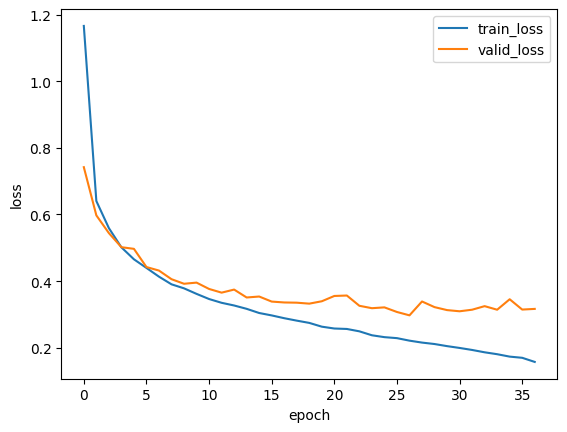

In [8]:
result_df[["train_loss", "valid_loss"]].plot(xlabel="epoch", ylabel="loss");

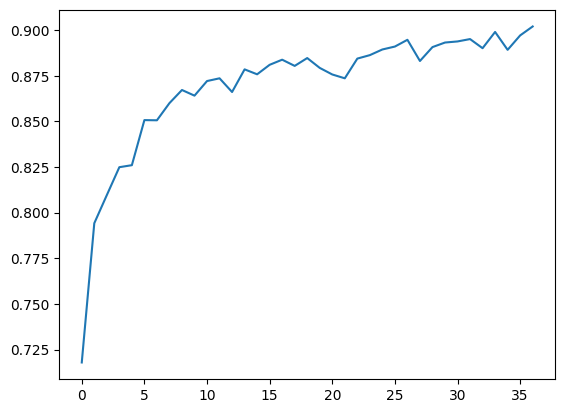

In [10]:
result_df['valid_acc'].plot();

In [11]:
result_df[["train_loss", "valid_loss"]].min()

train_loss    0.157350
valid_loss    0.297143
dtype: float64

In [12]:
result_df['valid_acc'].max()

np.float64(0.902)

In [13]:
# 저장된 모델 load
save_model_path = "saved_models/fashion_mnist_model.pth"
load_model = torch.load(save_model_path, weights_only=False)
load_model

FashionMNISTModel(
  (lr1): Linear(in_features=784, out_features=2048, bias=True)
  (lr2): Linear(in_features=2048, out_features=1024, bias=True)
  (lr3): Linear(in_features=1024, out_features=512, bias=True)
  (lr4): Linear(in_features=512, out_features=256, bias=True)
  (lr5): Linear(in_features=256, out_features=128, bias=True)
  (lr6): Linear(in_features=128, out_features=64, bias=True)
  (lr7): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [18]:
### Testset으로 최종 평가
load_model = load_model.to(device)
load_model.eval()
loss = 0.0
acc = 0.0
loss_fn = nn.CrossEntropyLoss()
with torch.no_grad():
    for X, y in f_test_loader:
        X, y = X.to(device), y.to(device) # 1. device로 옮기기
        pred = load_model(X) # 2. 모델 추론
        pred_label = pred.argmax(dim=-1)
        # 평가
        loss += loss_fn(pred, y).item()
        acc += torch.sum(y == pred_label).item()
    loss /= len(f_test_loader)
    acc /= len(f_testset)

print("loss:", loss)
print("accuracy:", acc)

loss: 0.3335733566433191
accuracy: 0.8833


In [24]:
p = nn.Softmax(dim=-1)(pred)

In [26]:
pred[:2]

tensor([[ 4.1520,  1.5371, -0.2541,  8.2770,  0.4474, -7.0903,  3.3835, -6.8558,
         -2.6592, -8.8808],
        [ 3.2736, -0.3634,  3.5475,  0.5031,  0.2289, -2.9125,  2.2069, -3.2826,
         -2.2528, -1.5481]])

In [29]:
p[:2]# .sum(dim=-1)

tensor([[1.5763e-02, 1.1534e-03, 1.9236e-04, 9.7518e-01, 3.8792e-04, 2.0662e-07,
         7.3093e-03, 2.6122e-07, 1.7361e-05, 3.4479e-08],
        [3.5570e-01, 9.3663e-03, 4.6779e-01, 2.2279e-02, 1.6935e-02, 7.3203e-04,
         1.2241e-01, 5.0555e-04, 1.4158e-03, 2.8645e-03]])

### 위스콘신 유방암 데이터셋 - **이진분류(Binary Classification) 문제**

-   **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
-   위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
-   Feature
    -   종양에 대한 다양한 측정값들
-   Target의 class
    -   0 - malignant(악성종양)
    -   1 - benign(양성종양)


In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
# Dataset
X, y = load_breast_cancer(return_X_y=True)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

In [3]:
# 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Dataset
## 모델의 weight, bias -> float32. X, y는 weight, bias와 계산을 하게 되기 때문에 타입을 맞춰준다.
trainset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),  
    torch.tensor(y_train, dtype=torch.float32)
)
testset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32), 
    torch.tensor(y_test, dtype=torch.float32)
)

In [5]:
# class name <-> class index
classes = np.array(["악성종양", "양성종양"])
class_to_idx = {"악성종양":0, "양성종양":1}

trainset.classes = classes
trainset.class_to_idx = class_to_idx

In [6]:
trainset.classes[[0, 1, 1, 0, 1,  1, 0, 1, 1]]

array(['악성종양', '양성종양', '양성종양', '악성종양', '양성종양', '양성종양', '악성종양', '양성종양',
       '양성종양'], dtype='<U4')

In [7]:
len(trainset), len(testset)

(426, 143)

In [8]:
# DataLoader
train_loader = DataLoader(trainset, batch_size=200, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=100)

In [9]:
X_train.shape

(426, 30)

In [10]:
######### 모델 정의
class BCModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(30, 16)
        self.lr2 = nn.Linear(16, 8)
        self.lr3 = nn.Linear(8, 1)  # out_features: 1 - positive일 확률
        self.relu = nn.ReLU() # hidden layer의 활성함수
        self.sigmoid = nn.Sigmoid()  # Linear 출력값을 0 ~ 1 확률로 만들어주는 Sigmoid(Logistic)함수.
    
    def forward(self, X):
        out = self.relu(self.lr1(X))
        out = self.relu(self.lr2(out))

        out = self.lr3(out)
        out = self.sigmoid(out)
        return out

In [47]:
from torchinfo import summary
m = BCModel()
summary(m)
# p = m(torch.randn(10, 30))
# p

Layer (type:depth-idx)                   Param #
BCModel                                  --
├─Linear: 1-1                            496
├─Linear: 1-2                            136
├─Linear: 1-3                            9
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 641
Trainable params: 641
Non-trainable params: 0

In [48]:
######### 학습
train_loss_list = []
valid_loss_list = []
valid_acc_list = []

epochs = 1000

model = BCModel().to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 조기종료, best 모델 저장
best_score = torch.inf  # valid loss 기준
save_model_path = "saved_models/bc_model.pth"
patience = 10
stop_count = 0

In [54]:
for epoch in range(epochs):
    # 학습
    model.train()
    train_loss = 0.0
    for X_train, y_train in train_loader:
        # 1. device로 이동
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 추론
        pred_train = model(X_train)
        # 3. loss
        loss = loss_fn(pred_train, y_train)
        # 4. gradient계산
        loss.backward()
        # 5. 파라미터 업데이트
        optimizer.step()
        # 6. 파라미터 초기화
        optimizer.zero_grad()
        # loss 누적
        train_loss += loss.item()
    
    # train loss 평균
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)
        
    # 검증
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for X_valid, y_valid in test_loader:
            # 1. device 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            # 2. 추론
            pred_valid = model(X_valid) # (batch, 1) 1축: positive일 확률
            pred_label = (pred_valid > 0.5).type(torch.int32) # label
            # 3. 평가 - loss, acc
            valid_loss += loss_fn(pred_valid, y_valid).item()
            valid_acc += torch.sum(pred_label == y_valid).item()
        
        valid_loss /= len(test_loader)
        valid_acc /= len(testset)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        print(f"[{epoch+1}/{epochs}] train loss: {train_loss:.5f}, valid loss{valid_loss:.5f}, valid acc: {valid_acc:.5f}")

        # 성능 개선시 모델 저장 + 조기종료
        if valid_loss < best_score: # 개선됨.
            # 모델 저장 + stop_count 초기화
            print(f">>>>>>>> {epoch+1} Epoch에서 모델을 저장합니다. {best_score}에서 {valid_loss}로 개선됨")        
            torch.save(model, save_model_path)
            best_score = valid_loss
            stop_count = 0
        else: # 개선안됨
            stop_count += 1
            if patience == stop_count:
                print(f"{epoch+1}에서 조기종료 합니다. {best_score}에서 개선이 안됨.")
                break

[1/1000] train loss: 0.64756, valid loss0.59831, valid acc: 0.68531
>>>>>>>> 1 Epoch에서 모델을 저장합니다. inf에서 0.5983078181743622로 개선됨
[2/1000] train loss: 0.59126, valid loss0.53053, valid acc: 0.88112
>>>>>>>> 2 Epoch에서 모델을 저장합니다. 0.5983078181743622에서 0.5305299460887909로 개선됨
[3/1000] train loss: 0.51114, valid loss0.45639, valid acc: 0.92308
>>>>>>>> 3 Epoch에서 모델을 저장합니다. 0.5305299460887909에서 0.4563935697078705로 개선됨
[4/1000] train loss: 0.43413, valid loss0.39584, valid acc: 0.90909
>>>>>>>> 4 Epoch에서 모델을 저장합니다. 0.4563935697078705에서 0.3958374559879303로 개선됨
[5/1000] train loss: 0.36936, valid loss0.35343, valid acc: 0.90909
>>>>>>>> 5 Epoch에서 모델을 저장합니다. 0.3958374559879303에서 0.35342937707901로 개선됨
[6/1000] train loss: 0.31789, valid loss0.31951, valid acc: 0.90909
>>>>>>>> 6 Epoch에서 모델을 저장합니다. 0.35342937707901에서 0.3195130079984665로 개선됨
[7/1000] train loss: 0.28655, valid loss0.28657, valid acc: 0.91608
>>>>>>>> 7 Epoch에서 모델을 저장합니다. 0.3195130079984665에서 0.28656579554080963로 개선됨
[8/1000] train lo

In [57]:
######### 저장된 모델 로드
load_bc_model = torch.load(save_model_path, weights_only=False)
load_bc_model

BCModel(
  (lr1): Linear(in_features=30, out_features=16, bias=True)
  (lr2): Linear(in_features=16, out_features=8, bias=True)
  (lr3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [65]:
###### 추론 함수 #######
def predict_bc(model, X, device="cpu"):
    # model로 X를 추론한 결과를 반환
    # label, 확률
    result = []
    with torch.no_grad():
        pred_proba = model(X) # POS 확률
        pred_class = (pred_proba > 0.5).type(torch.int32)
        for class_index, proba in zip(pred_class, pred_proba):
            # print(class_index, proba if class_index.item() == 1 else 1-proba)
            result.append((class_index.item(), proba.item() if class_index.item() == 1 else 1-proba.item()))
        return result

In [ ]:
@torch.no_grad
def predict_bc(model, X, device="cpu"):
    # model로 X를 추론한 결과를 반환
    # label, 확률
    result = []
    
    pred_proba = model(X) # POS 확률
    pred_class = (pred_proba > 0.5).type(torch.int32)
    for class_index, proba in zip(pred_class, pred_proba):
        # print(class_index, proba if class_index.item() == 1 else 1-proba)
        result.append((class_index.item(), proba.item() if class_index.item() == 1 else 1-proba.item()))
    return result

In [66]:
new_data = torch.tensor(X_test_scaled[:5], dtype=torch.float32)

In [67]:
result = predict_bc(load_bc_model, new_data)
result

[(1, 0.9759008884429932),
 (0, 0.9999994845734363),
 (0, 0.9999653625418432),
 (1, 0.993977427482605),
 (0, 0.9997869370126864)]

In [68]:
y_test[:5]

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [ ]:
model = BCModel().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
from module.train import fit

result = fit(
    train_loader, test_loader, model, loss_fn, optimizer, 
    epochs=1000, save_best_model=True, save_model_path="saved_models/bc_model2.pth", 
    device=device
)

Epoch[1/1000] - Train loss: 0.16901 Train Accucracy: 0.88498 || Validation Loss: 0.21779 Validation Accuracy: 0.90909
저장: 1 - 이전 : inf, 현재: 0.21779108047485352
Epoch[2/1000] - Train loss: 0.08153 Train Accucracy: 0.92254 || Validation Loss: 0.16598 Validation Accuracy: 0.94406
저장: 2 - 이전 : 0.21779108047485352, 현재: 0.1659836433827877
Epoch[3/1000] - Train loss: 0.11448 Train Accucracy: 0.91080 || Validation Loss: 0.34324 Validation Accuracy: 0.92308
Epoch[4/1000] - Train loss: 0.07925 Train Accucracy: 0.92723 || Validation Loss: 0.34212 Validation Accuracy: 0.95105
Epoch[5/1000] - Train loss: 0.07638 Train Accucracy: 0.92723 || Validation Loss: 0.28102 Validation Accuracy: 0.94406
Epoch[6/1000] - Train loss: 0.06307 Train Accucracy: 0.92723 || Validation Loss: 0.28663 Validation Accuracy: 0.95105
Epoch[7/1000] - Train loss: 0.04774 Train Accucracy: 0.92254 || Validation Loss: 0.24003 Validation Accuracy: 0.95105
Epoch[8/1000] - Train loss: 0.03414 Train Accucracy: 0.92723 || Validation 

# 모델 유형별 구현 정리

## 공통

-   Input layer(첫번째 Layer)의 in_features
    -   입력데이터의 feature(속성) 개수에 맞춰준다.
-   Hidden layer 수
    -   경험적(art)으로 정한다.
    -   Hidden layer에 Linear를 사용하는 경우 보통 feature 수를 줄여 나간다. (핵심 특성들을 추출해나가는 과정의 개념.)

## 회귀 모델

-   output layer의 출력 unit개수(out_features)
    -   정답의 개수
    -   ex
        -   집값: 1
        -   아파트가격, 단독가격, 빌라가격: 3 => y의 개수에 맞춘다.
-   출력 Layer에 적용하는 activation 함수
    -   일반적으로 **None**
    -   값의 범위가 설정되 있고 그 범위의 값을 출력하는 함수가 있을 경우
        -   ex) 0 ~ 1: logistic(Sigmoid), -1 ~ 1: hyperbolic tangent(Tanh)
-   loss함수
    -   MSELoss
-   평가지표
    -   MSE, RMSE, R square($R^2$)

## 다중분류 모델

-   output layer의 unit 개수
    -   정답 class(고유값)의 개수
-   출력 Layer에 적용하는 activation 함수
    -   Softmax: 클래스별 확률을 출력
-   loss함수
    -   **categrocial crossentropy**
    -   파이토치 함수
        -   **CrossEntropyLoss** = NLLLoss(정답) + LogSoftmax(모델 예측값)
        -   **NLLLoss**
            -   정답을 OneHot Encoding 처리 후 Loss를 계산한다.
            -   입력으로 LogSoftmax 처리한 모델 예측값과 onehot encoding 안 된 정답을 받는다.
        -   **LogSoftmax**
            -   입력값에 Softmax 계산후 그 Log를 계산한다.
                -   NLLLoss의 모델 예측값 입력값으로 처리할 때 사용한다.

```python
pred = model(input)
loss1 = nn.NLLLoss(nn.LogSoftmax(dim=-1)(pred), y)
# or
loss2 = nn.CrossEntropyLoss()(pred, y)
```

## 이진분류 모델

-   output layer의 unit 개수
    -   1개 (positive일 확률)
-   출력 Layer에 적용하는 activation 함수
    -   Sigmoid(Logistic)
-   loss 함수
    -   **Binary crossentropy**
    -   파이토치 함수: **BCELoss**
